In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=26ef03daeca3c3022ea87fc72579e5316a4bf949e64e2dcc0c1cf4d202411778
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6185ba4ed718effe7a5ec4091b260b2b9681269801890cf1d74af192bd6e5b76
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import os
import gc 
import cv2
import random

from tqdm.auto import tqdm
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
def seed_everything(seed=100):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [4]:
# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 100   
LR = 0.0001    
IMG_SIZE = 256 
BATCH_SIZE = 8

In [5]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels",x),masks)})
print(train_df.shape)
del images, masks
train_df.head()

(126, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...


In [6]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels",x),masks)})
print(val_df.shape)
del images, masks
val_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...


In [7]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels",x),masks)})
print(test_df.shape)
del images, masks
test_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...


In [8]:
def encode_labels(masks):
    labelencoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1)
    masks_encoded = labelencoder.fit_transform(masks_reshaped)
    del masks_reshaped, labelencoder
    return masks_encoded.reshape(masks.shape)

In [33]:
# Create a custom dataset class
classes=9
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        images=[]
        masks=[]
        for idx in range(len(self.df)):
            sample = self.df.iloc[idx]
            images.append(load_img(sample.images, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
            masks.append(load_img(sample.masks, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
#             images.append(cv2.resize(cv2.imread(sample.images, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
#             masks.append(cv2.resize(cv2.imread(sample.masks, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
        images = np.array(images)
        masks = np.array(masks)
        n_classes = classes #len(np.unique(masks))
        masks_encoded = encode_labels(masks)
        self.masks_cat = to_categorical(masks_encoded, num_classes=n_classes)
        self.images = np.expand_dims(images, axis=-1) / 255.0
        del masks_encoded, images, masks, n_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.transpose(self.images[idx],(2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(self.masks_cat[idx],(2, 0, 1))).float()
        return image, mask

In [10]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df)
val_data = SegmentationDataset(val_df)
test_data = SegmentationDataset(test_df)

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 16
Total number of batches in Val Loader: 5


In [14]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([8, 1, 256, 256])
Size of one batch of masks: torch.Size([8, 9, 256, 256])


In [15]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

In [16]:
def dice_score(y_true, y_pred):
    return 1.0-DiceLoss(mode="binary")(y_true, y_pred)
            
def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

In [17]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x, masks):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        loss = DiceLoss(mode='binary')(logits, masks)
        score = dice_score(logits, masks)
        return logits, loss, score

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [34]:
model = UNet(n_channels=1, n_classes=classes)
model.to(DEVICE);

In [35]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss, score = model(images, masks)
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [36]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss, score = model(images, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [37]:
# Define the optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [38]:
gc.collect()

1540

In [39]:
# Training and evaluation loop
best_val_loss = 1e9
writer=SummaryWriter("DiceLoss_Clean_Dataset")
for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_DiceLoss_Clean_model_SD.pt')
        torch.save(model, 'best_DiceLoss_Clean_model.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i+1} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train dice_score {train_score} Val dice_score {val_score}")
writer.close()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.7277345210313797 Val DiceLoss 0.7856343626976013 Train dice_score 0.2722654789686203 Val dice_score 0.2143656373023987


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.6834192350506783 Val DiceLoss 0.7343845129013061 Train dice_score 0.31658076494932175 Val dice_score 0.26561548709869387


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.6665582656860352 Val DiceLoss 0.6992692947387695 Train dice_score 0.33344173431396484 Val dice_score 0.30073070526123047


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.6520703062415123 Val DiceLoss 0.6543309807777404 Train dice_score 0.3479296937584877 Val dice_score 0.3456690192222595


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.6389484219253063 Val DiceLoss 0.6392664432525634 Train dice_score 0.3610515780746937 Val dice_score 0.3607335567474365


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.626957856118679 Val DiceLoss 0.6237242579460144 Train dice_score 0.37304214388132095 Val dice_score 0.3762757420539856


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.6155819334089756 Val DiceLoss 0.6115751743316651 Train dice_score 0.3844180665910244 Val dice_score 0.38842482566833497


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.6038677208125591 Val DiceLoss 0.6012124300003052 Train dice_score 0.39613227918744087 Val dice_score 0.39878756999969484


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 9 Train DiceLoss 0.5921934545040131 Val DiceLoss 0.5896201729774475 Train dice_score 0.40780654549598694 Val dice_score 0.4103798270225525


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.5803525969386101 Val DiceLoss 0.5787227630615235 Train dice_score 0.4196474030613899 Val dice_score 0.4212772369384766


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.5681658200919628 Val DiceLoss 0.5649271607398987 Train dice_score 0.4318341799080372 Val dice_score 0.4350728392601013


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.5562864504754543 Val DiceLoss 0.554977548122406 Train dice_score 0.44371354952454567 Val dice_score 0.445022451877594


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 13 Train DiceLoss 0.5441923923790455 Val DiceLoss 0.5399548053741455 Train dice_score 0.4558076076209545 Val dice_score 0.46004519462585447


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.5322156324982643 Val DiceLoss 0.5296050190925599 Train dice_score 0.4677843675017357 Val dice_score 0.4703949809074402


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 15 Train DiceLoss 0.5204878374934196 Val DiceLoss 0.5136055827140809 Train dice_score 0.47951216250658035 Val dice_score 0.4863944172859192


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.5080340728163719 Val DiceLoss 0.5029596805572509 Train dice_score 0.4919659271836281 Val dice_score 0.497040319442749


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.4958758242428303 Val DiceLoss 0.4904337882995605 Train dice_score 0.5041241757571697 Val dice_score 0.5095662117004395


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.48282909393310547 Val DiceLoss 0.47319129705429075 Train dice_score 0.5171709060668945 Val dice_score 0.5268087029457093


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 19 Train DiceLoss 0.47809791564941406 Val DiceLoss 0.5451225757598877 Train dice_score 0.5219020843505859 Val dice_score 0.4548774242401123


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.4577641896903515 Val DiceLoss 0.45541681051254274 Train dice_score 0.5422358103096485 Val dice_score 0.5445831894874573


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.4438965320587158 Val DiceLoss 0.43887569904327395 Train dice_score 0.5561034679412842 Val dice_score 0.561124300956726


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.4311532974243164 Val DiceLoss 0.4242874264717102 Train dice_score 0.5688467025756836 Val dice_score 0.5757125735282898


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.41847558692097664 Val DiceLoss 0.41413016319274903 Train dice_score 0.5815244130790234 Val dice_score 0.585869836807251


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.40614190325140953 Val DiceLoss 0.3982299089431763 Train dice_score 0.5938580967485905 Val dice_score 0.6017700910568238


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.3938274011015892 Val DiceLoss 0.3903029203414917 Train dice_score 0.6061725988984108 Val dice_score 0.6096970796585083


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.38163958489894867 Val DiceLoss 0.379140305519104 Train dice_score 0.6183604151010513 Val dice_score 0.620859694480896


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.3694303222000599 Val DiceLoss 0.3604754090309143 Train dice_score 0.6305696777999401 Val dice_score 0.6395245909690856


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 28 Train DiceLoss 0.35635167360305786 Val DiceLoss 0.3412386059761047 Train dice_score 0.6436483263969421 Val dice_score 0.6587613940238952


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.34456995502114296 Val DiceLoss 0.34070185422897337 Train dice_score 0.655430044978857 Val dice_score 0.6592981457710266


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.3323493227362633 Val DiceLoss 0.3265022158622742 Train dice_score 0.6676506772637367 Val dice_score 0.6734977841377259


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 31 Train DiceLoss 0.321246650069952 Val DiceLoss 0.3184422492980957 Train dice_score 0.678753349930048 Val dice_score 0.6815577507019043


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 32 Train DiceLoss 0.3102435730397701 Val DiceLoss 0.3040947079658508 Train dice_score 0.6897564269602299 Val dice_score 0.6959052920341492


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.2995220124721527 Val DiceLoss 0.29348996877670286 Train dice_score 0.7004779875278473 Val dice_score 0.7065100312232971


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 34 Train DiceLoss 0.28908995166420937 Val DiceLoss 0.28399474620819093 Train dice_score 0.7109100483357906 Val dice_score 0.7160052537918091


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.2788149081170559 Val DiceLoss 0.2732190012931824 Train dice_score 0.7211850918829441 Val dice_score 0.7267809987068177


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 36 Train DiceLoss 0.26896943524479866 Val DiceLoss 0.26048827171325684 Train dice_score 0.7310305647552013 Val dice_score 0.7395117282867432


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.2594388499855995 Val DiceLoss 0.2543837785720825 Train dice_score 0.7405611500144005 Val dice_score 0.7456162214279175


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.251083679497242 Val DiceLoss 0.2482546329498291 Train dice_score 0.748916320502758 Val dice_score 0.7517453670501709


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.2428303360939026 Val DiceLoss 0.24194779396057128 Train dice_score 0.7571696639060974 Val dice_score 0.7580522060394287


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.23338373005390167 Val DiceLoss 0.23111175298690795 Train dice_score 0.7666162699460983 Val dice_score 0.768888247013092


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.22484202682971954 Val DiceLoss 0.22204049825668334 Train dice_score 0.7751579731702805 Val dice_score 0.7779595017433166


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.21642806753516197 Val DiceLoss 0.2121359586715698 Train dice_score 0.783571932464838 Val dice_score 0.7878640413284301


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.2088119387626648 Val DiceLoss 0.20596896409988402 Train dice_score 0.7911880612373352 Val dice_score 0.7940310359001159


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 44 Train DiceLoss 0.20128241181373596 Val DiceLoss 0.19844374656677247 Train dice_score 0.798717588186264 Val dice_score 0.8015562534332276


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 45 Train DiceLoss 0.19395210966467857 Val DiceLoss 0.19127570390701293 Train dice_score 0.8060478903353214 Val dice_score 0.808724296092987


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 46 Train DiceLoss 0.1869513802230358 Val DiceLoss 0.18444443941116334 Train dice_score 0.8130486197769642 Val dice_score 0.8155555605888367


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.18014627322554588 Val DiceLoss 0.17816829681396484 Train dice_score 0.8198537267744541 Val dice_score 0.8218317031860352


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 48 Train DiceLoss 0.17373213917016983 Val DiceLoss 0.17250850200653076 Train dice_score 0.8262678608298302 Val dice_score 0.8274914979934692


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.16741567477583885 Val DiceLoss 0.16719334125518798 Train dice_score 0.8325843252241611 Val dice_score 0.832806658744812


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 50 Train DiceLoss 0.16144511476159096 Val DiceLoss 0.16058562994003295 Train dice_score 0.838554885238409 Val dice_score 0.839414370059967


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 51 Train DiceLoss 0.15554523095488548 Val DiceLoss 0.1538317918777466 Train dice_score 0.8444547690451145 Val dice_score 0.8461682081222535


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.15003742277622223 Val DiceLoss 0.14743951559066773 Train dice_score 0.8499625772237778 Val dice_score 0.8525604844093323


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 53 Train DiceLoss 0.14475396275520325 Val DiceLoss 0.14353195428848267 Train dice_score 0.8552460372447968 Val dice_score 0.8564680457115174


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 54 Train DiceLoss 0.13948208093643188 Val DiceLoss 0.13995285034179689 Train dice_score 0.8605179190635681 Val dice_score 0.8600471496582032


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 55 Train DiceLoss 0.13445378094911575 Val DiceLoss 0.1339275360107422 Train dice_score 0.8655462190508842 Val dice_score 0.8660724639892579


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 56 Train DiceLoss 0.12976408749818802 Val DiceLoss 0.12815982103347778 Train dice_score 0.870235912501812 Val dice_score 0.8718401789665222


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.1251869648694992 Val DiceLoss 0.12431416511535645 Train dice_score 0.8748130351305008 Val dice_score 0.8756858348846436


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.12073960155248642 Val DiceLoss 0.12015758752822876 Train dice_score 0.8792603984475136 Val dice_score 0.8798424124717712


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.11665128916501999 Val DiceLoss 0.11383494138717651 Train dice_score 0.88334871083498 Val dice_score 0.8861650586128235


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.11236855015158653 Val DiceLoss 0.11252602338790893 Train dice_score 0.8876314498484135 Val dice_score 0.887473976612091


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 61 Train DiceLoss 0.12380219623446465 Val DiceLoss 0.1590093493461609 Train dice_score 0.8761978037655354 Val dice_score 0.8409906506538392


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.10728863626718521 Val DiceLoss 0.1117432713508606 Train dice_score 0.8927113637328148 Val dice_score 0.8882567286491394


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.1020616814494133 Val DiceLoss 0.10431604385375977 Train dice_score 0.8979383185505867 Val dice_score 0.8956839561462402


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 64 Train DiceLoss 0.09816740825772285 Val DiceLoss 0.09825422763824462 Train dice_score 0.9018325917422771 Val dice_score 0.9017457723617553


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.09468968957662582 Val DiceLoss 0.09402209520339966 Train dice_score 0.9053103104233742 Val dice_score 0.9059779047966003


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 66 Train DiceLoss 0.091414924710989 Val DiceLoss 0.0902930736541748 Train dice_score 0.908585075289011 Val dice_score 0.9097069263458252


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.08830699324607849 Val DiceLoss 0.0872310757637024 Train dice_score 0.9116930067539215 Val dice_score 0.9127689242362976


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.08535150066018105 Val DiceLoss 0.08427693843841552 Train dice_score 0.914648499339819 Val dice_score 0.9157230615615845


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.08251987025141716 Val DiceLoss 0.0815664529800415 Train dice_score 0.9174801297485828 Val dice_score 0.9184335470199585


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.07981175929307938 Val DiceLoss 0.07889933586120605 Train dice_score 0.9201882407069206 Val dice_score 0.921100664138794


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 71 Train DiceLoss 0.0772218368947506 Val DiceLoss 0.07641223669052125 Train dice_score 0.9227781631052494 Val dice_score 0.9235877633094788


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.0747276023030281 Val DiceLoss 0.07406048774719239 Train dice_score 0.9252723976969719 Val dice_score 0.9259395122528076


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 73 Train DiceLoss 0.07232747226953506 Val DiceLoss 0.07160778045654297 Train dice_score 0.9276725277304649 Val dice_score 0.9283922195434571


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.07029209285974503 Val DiceLoss 0.06911290884017944 Train dice_score 0.929707907140255 Val dice_score 0.9308870911598206


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 75 Train DiceLoss 0.06787928193807602 Val DiceLoss 0.06731027364730835 Train dice_score 0.932120718061924 Val dice_score 0.9326897263526917


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 76 Train DiceLoss 0.06584270671010017 Val DiceLoss 0.06550564765930175 Train dice_score 0.9341572932898998 Val dice_score 0.9344943523406982


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 77 Train DiceLoss 0.06375551968812943 Val DiceLoss 0.06337288618087769 Train dice_score 0.9362444803118706 Val dice_score 0.9366271138191223


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 78 Train DiceLoss 0.06182136386632919 Val DiceLoss 0.06236844062805176 Train dice_score 0.9381786361336708 Val dice_score 0.9376315593719482


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 79 Train DiceLoss 0.060124967247247696 Val DiceLoss 0.06007272005081177 Train dice_score 0.9398750327527523 Val dice_score 0.9399272799491882


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.0583203062415123 Val DiceLoss 0.0586104154586792 Train dice_score 0.9416796937584877 Val dice_score 0.9413895845413208


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 81 Train DiceLoss 0.056559816002845764 Val DiceLoss 0.055885493755340576 Train dice_score 0.9434401839971542 Val dice_score 0.9441145062446594


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 82 Train DiceLoss 0.05487813428044319 Val DiceLoss 0.05472002029418945 Train dice_score 0.9451218657195568 Val dice_score 0.9452799797058106


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 83 Train DiceLoss 0.05319783091545105 Val DiceLoss 0.053652966022491456 Train dice_score 0.946802169084549 Val dice_score 0.9463470339775085


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 84 Train DiceLoss 0.05178963392972946 Val DiceLoss 0.05150599479675293 Train dice_score 0.9482103660702705 Val dice_score 0.9484940052032471


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 85 Train DiceLoss 0.05020105093717575 Val DiceLoss 0.04999787807464599 Train dice_score 0.9497989490628242 Val dice_score 0.950002121925354


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 86 Train DiceLoss 0.04896608367562294 Val DiceLoss 0.04933838844299317 Train dice_score 0.9510339163243771 Val dice_score 0.9506616115570068


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.04745950177311897 Val DiceLoss 0.0482653021812439 Train dice_score 0.952540498226881 Val dice_score 0.9517346978187561


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 88 Train DiceLoss 0.04619857668876648 Val DiceLoss 0.04679926633834839 Train dice_score 0.9538014233112335 Val dice_score 0.9532007336616516


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 89 Train DiceLoss 0.04502870887517929 Val DiceLoss 0.04562761783599854 Train dice_score 0.9549712911248207 Val dice_score 0.9543723821640014


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 90 Train DiceLoss 0.04374092072248459 Val DiceLoss 0.04432990550994873 Train dice_score 0.9562590792775154 Val dice_score 0.9556700944900512


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 91 Train DiceLoss 0.04255249723792076 Val DiceLoss 0.04276067018508911 Train dice_score 0.9574475027620792 Val dice_score 0.9572393298149109


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 92 Train DiceLoss 0.0415273979306221 Val DiceLoss 0.044229114055633546 Train dice_score 0.9584726020693779 Val dice_score 0.9557708859443664


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 93 Train DiceLoss 0.04030118137598038 Val DiceLoss 0.041725337505340576 Train dice_score 0.9596988186240196 Val dice_score 0.9582746624946594


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 94 Train DiceLoss 0.03933021426200867 Val DiceLoss 0.04063384532928467 Train dice_score 0.9606697857379913 Val dice_score 0.9593661546707153


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 95 Train DiceLoss 0.038159292191267014 Val DiceLoss 0.04007495641708374 Train dice_score 0.961840707808733 Val dice_score 0.9599250435829163


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 96 Train DiceLoss 0.037518713623285294 Val DiceLoss 0.03899844884872437 Train dice_score 0.9624812863767147 Val dice_score 0.9610015511512756


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 97 Train DiceLoss 0.03656093031167984 Val DiceLoss 0.03877713680267334 Train dice_score 0.9634390696883202 Val dice_score 0.9612228631973266


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 98 Train DiceLoss 0.0354791097342968 Val DiceLoss 0.03733522891998291 Train dice_score 0.9645208902657032 Val dice_score 0.9626647710800171


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 99 Train DiceLoss 0.03454263135790825 Val DiceLoss 0.03677928447723389 Train dice_score 0.9654573686420918 Val dice_score 0.9632207155227661


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 100 Train DiceLoss 0.03386681526899338 Val DiceLoss 0.038597571849823 Train dice_score 0.9661331847310066 Val dice_score 0.961402428150177


In [40]:
original=[]
imgs=[]
pred=[]
model=model.eval()
with torch.no_grad():
    for images, masks in tqdm(testloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits, loss, score = model(images, masks)
        mask=logits[0].cpu().detach().numpy()
        predicted_masks=np.transpose(mask.squeeze(),(1,2,0))
        predicted_labels = np.argmax(predicted_masks, axis=-1)
        
        image_gt=images[0].squeeze().cpu().detach().numpy()
        
        mask_gt=masks[0].cpu().detach().numpy()
        predicted_masks_gt=np.transpose(mask_gt.squeeze(),(1,2,0))
        predicted_labels_gt = np.argmax(predicted_masks_gt, axis=-1)
        original.append(predicted_labels_gt)
        pred.append(predicted_labels)
        imgs.append(image_gt)
        del images,masks,logits, loss, score,mask, predicted_masks, predicted_labels, mask_gt, predicted_masks_gt, predicted_labels_gt

  0%|          | 0/40 [00:00<?, ?it/s]

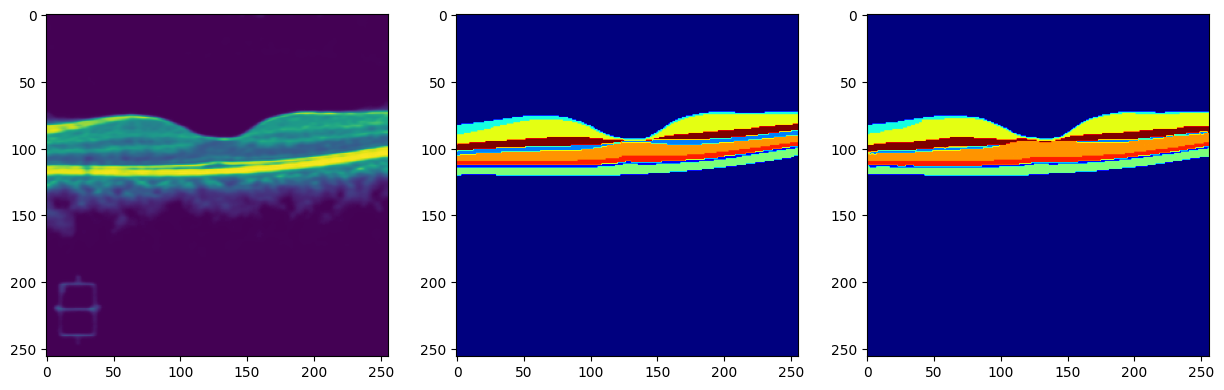

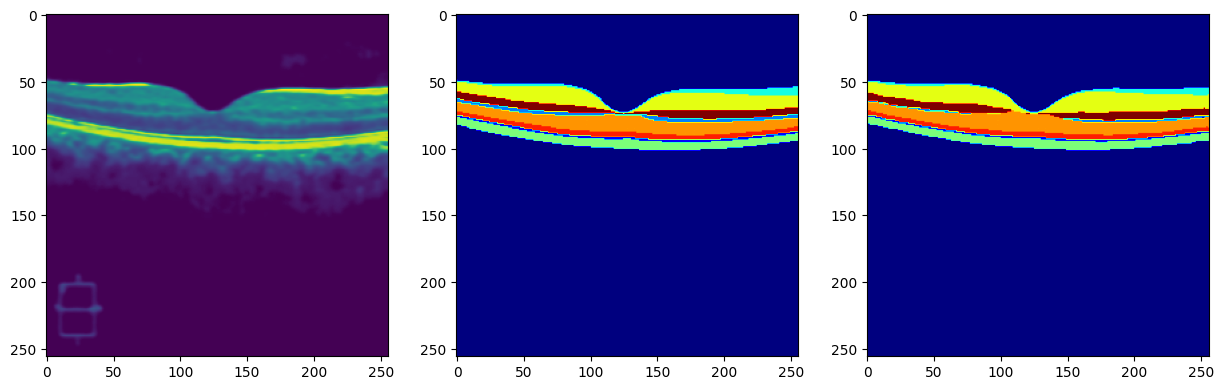

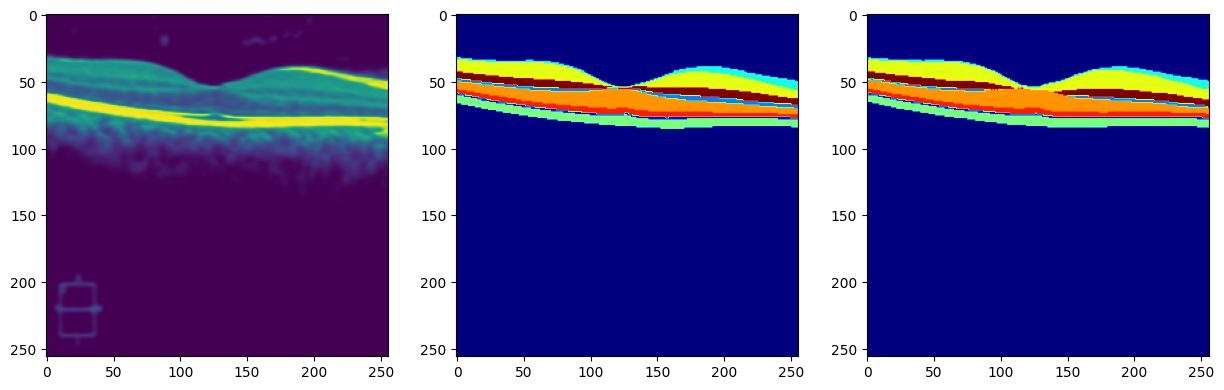

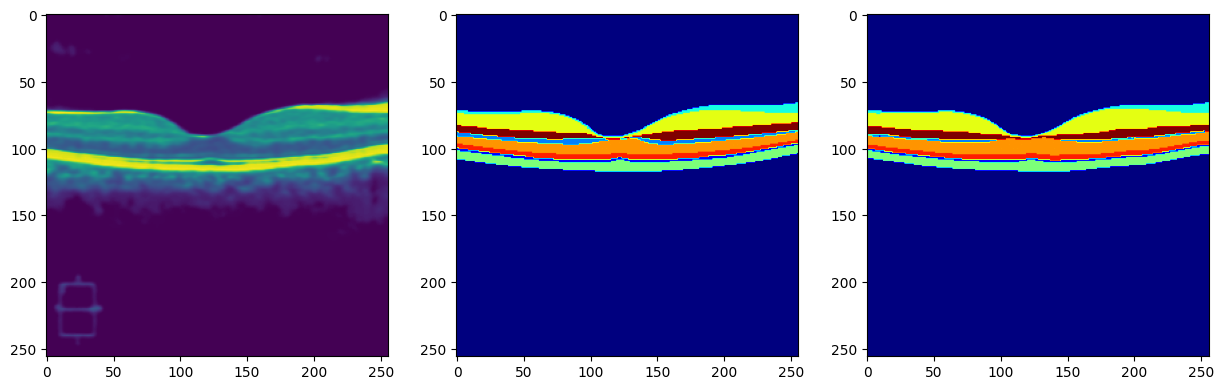

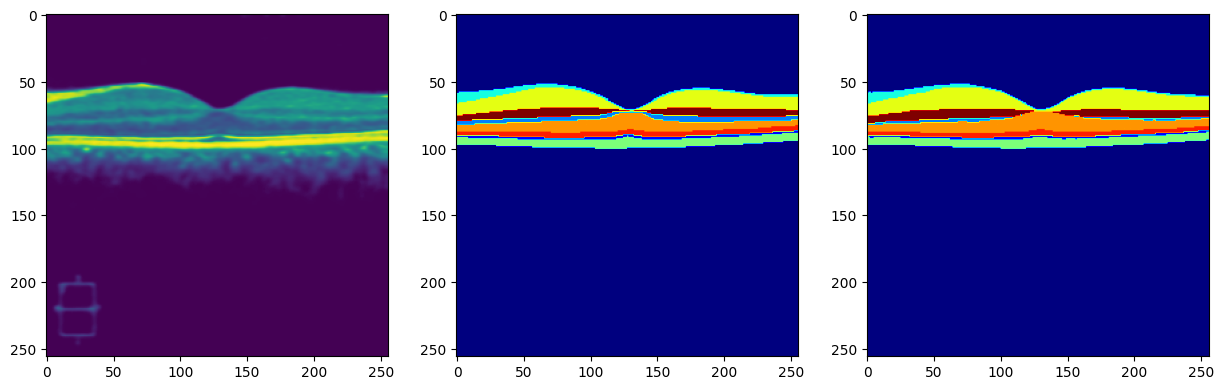

In [41]:
i=0
for img, org, msk in zip(imgs, original, pred):
#     print(org.shape,msk.shape)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,3)
    plt.imshow(msk,cmap="jet")
    plt.show()
    i+=1
    if i==5:
        break